In [1]:
!pip install thop

# CSPDNet Building and Training

In [2]:
# Cell 1: Model Architecture and Training Code
import os
import time
import random
import shutil
import argparse
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import csv
import json
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import transforms

#-------------------------------------------------------------------------------
# PART 1: MODEL ARCHITECTURE
#-------------------------------------------------------------------------------

class Conv(nn.Module):
    """Basic convolution layer"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=None, groups=1):
        super().__init__()
        if padding is None:
            padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, groups=groups, bias=False)
    
    def forward(self, x):
        return self.conv(x)

class BN(nn.Module):
    """Batch normalization layer"""
    def __init__(self, channels):
        super().__init__()
        self.bn = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        return self.bn(x)

class SiLU(nn.Module):
    """SiLU activation"""
    def __init__(self):
        super().__init__()
        self.silu = nn.SiLU()
    
    def forward(self, x):
        return self.silu(x)

class CBS(nn.Module):
    """Conv + BN + SiLU (as shown in diagram)"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=None):
        super().__init__()
        if padding is None:
            padding = (kernel_size - 1) // 2
        self.conv = Conv(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = BN(out_channels)
        self.silu = SiLU()
    
    def forward(self, x):
        return self.silu(self.bn(self.conv(x)))

class DWConv(nn.Module):
    """Depthwise Convolution"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=None):
        super().__init__()
        if padding is None:
            padding = (kernel_size - 1) // 2
        self.dw_conv = Conv(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pw_conv = Conv(in_channels, out_channels, kernel_size=1)
        self.bn = BN(out_channels)
        self.silu = SiLU()
    
    def forward(self, x):
        x = self.dw_conv(x)
        x = self.pw_conv(x)
        x = self.bn(x)
        x = self.silu(x)
        return x

class ChannelWeightingModule(nn.Module):
    """Channel Weighting Module as described in the paper"""
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            Conv(channels, channels // 16, kernel_size=1),
            SiLU(),
            Conv(channels // 16, channels, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        weights = self.weight(x)
        return x * weights

class DSCBlock(nn.Module):
    """Deformable Separate Convolutional Block as described in the paper"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Since we can't use actual deformable convolutions in PyTorch without custom CUDA code,
        # we'll simulate similar behavior with a standard DWConv followed by channel weighting
        self.dw_conv = DWConv(in_channels, in_channels)
        self.channel_weighting = ChannelWeightingModule(in_channels)
        self.pw_conv = Conv(in_channels, out_channels, kernel_size=1)
        self.bn = BN(out_channels)
        self.silu = SiLU()
    
    def forward(self, x):
        x = self.dw_conv(x)
        x = self.channel_weighting(x)
        x = self.pw_conv(x)
        x = self.bn(x)
        x = self.silu(x)
        return x

class CSPDBlock(nn.Module):
    """Cross Stage Partial Deformable Block as shown in diagram"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        mid_channels = out_channels // 2
        
        # First part: split input into two parts
        self.split_conv1 = CBS(in_channels, mid_channels, kernel_size=1)
        self.split_conv2 = CBS(in_channels, mid_channels, kernel_size=1)
        
        # DSCBlock for processing
        self.dscblock = DSCBlock(mid_channels, mid_channels)
        
        # CBS for further processing
        self.cbs = CBS(mid_channels, mid_channels)
        
        # Final 1x1 conv after concatenation
        self.final_conv = CBS(mid_channels * 2, out_channels, kernel_size=1)
    
    def forward(self, x):
        # Split input into two paths
        x0 = self.split_conv1(x)  # x'₀
        x0_skip = self.split_conv2(x)  # x''₀
        
        # Process through DSCBlock
        xt = self.dscblock(x0_skip)
        
        # Process through CBS
        xk = self.cbs(xt)
        
        # Concatenate x'₀ and xk
        xu = torch.cat([x0, xk], dim=1)
        
        # Final 1x1 convolution
        output = self.final_conv(xu)
        
        return output

class SPPF(nn.Module):
    """Spatial Pyramid Pooling - Fast (SPPF) layer as shown in the diagram"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        mid_channels = in_channels // 2
        
        # Initial 1x1 convolution to reduce channels
        self.cv1 = CBS(in_channels, mid_channels, kernel_size=1)
        
        # MaxPool operations
        self.maxpool1 = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        
        # Final 1x1 convolution after concatenation
        self.cv2 = CBS(mid_channels * 4, out_channels, kernel_size=1)
    
    def forward(self, x):
        x = self.cv1(x)
        
        y1 = x
        y2 = self.maxpool1(x)
        y3 = self.maxpool1(y2)
        y4 = self.maxpool1(y3)
        
        # Concatenate all features
        out = torch.cat([y1, y2, y3, y4], dim=1)
        out = self.cv2(out)
        
        return out

class CSPDBackbone(nn.Module):
    """CSPD Backbone as shown in the diagram"""
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        # Initial convolution
        self.conv1 = CBS(in_channels, base_channels)
        
        # First downsample
        self.down1 = CBS(base_channels, base_channels * 2, stride=2)
        self.cbs1 = CBS(base_channels * 2, base_channels * 2)
        self.cspd1 = CSPDBlock(base_channels * 2, base_channels * 2)
        
        # Second downsample
        self.down2 = CBS(base_channels * 2, base_channels * 4, stride=2)
        self.cspd2 = CSPDBlock(base_channels * 4, base_channels * 4)
        
        # Third downsample
        self.down3 = CBS(base_channels * 4, base_channels * 8, stride=2)
        self.cspd3 = CSPDBlock(base_channels * 8, base_channels * 8)
        
        # Fourth downsample
        self.down4 = CBS(base_channels * 8, base_channels * 16, stride=2)
        self.cspd4 = CSPDBlock(base_channels * 16, base_channels * 16)
    
    def forward(self, x):
        # Initial convolution
        x = self.conv1(x)
        
        # First downsample
        x = self.down1(x)
        x = self.cbs1(x)
        c1 = self.cspd1(x)
        
        # Second downsample
        x = self.down2(c1)
        c2 = self.cspd2(x)
        
        # Third downsample
        x = self.down3(c2)
        c3 = self.cspd3(x)
        
        # Fourth downsample
        x = self.down4(c3)
        c4 = self.cspd4(x)
        
        return [c1, c2, c3, c4]

class PAFPNCSPD(nn.Module):
    """Path Aggregation Feature Pyramid Network with CSPD blocks as shown in the diagram"""
    def __init__(self, channels_list):
        super().__init__()
        c2_ch, c3_ch, c4_ch, c5_ch = channels_list
        
        # SPPF
        self.sppf = SPPF(c5_ch, c5_ch)
        
        # Top-down pathway (from P5 to P3)
        self.up_conv1 = CBS(c5_ch, c4_ch, kernel_size=1)
        # Fix: Account for the concatenation of c4_ch + c4_ch (after upsampling)
        self.cspd_p4 = CSPDBlock(c4_ch + c4_ch, c4_ch)  
        
        self.up_conv2 = CBS(c4_ch, c3_ch, kernel_size=1)
        # Fix: Account for the concatenation of c3_ch + c3_ch (after upsampling)
        self.cspd_p3 = CSPDBlock(c3_ch + c3_ch, c3_ch)  
        
        self.up_conv3 = CBS(c3_ch, c2_ch, kernel_size=1)
        # Fix: Account for the concatenation of c2_ch + c2_ch (after upsampling)
        self.cspd_p2 = CSPDBlock(c2_ch + c2_ch, c2_ch)  
        
        # Bottom-up pathway (from P2 to P5)
        self.down_conv1 = CBS(c2_ch, c3_ch, stride=2)
        # Fix: Account for the concatenation of c3_ch + c3_ch (from p3 and downsampled p2)
        self.cspd_n3 = CSPDBlock(c3_ch + c3_ch, c3_ch)  
        
        self.down_conv2 = CBS(c3_ch, c4_ch, stride=2)
        # Fix: Account for the concatenation of c4_ch + c4_ch (from p4 and downsampled n3)
        self.cspd_n4 = CSPDBlock(c4_ch + c4_ch, c4_ch)  
        
        self.down_conv3 = CBS(c4_ch, c5_ch, stride=2)
        # Fix: Account for the concatenation of c5_ch + c5_ch (from p5 and downsampled n4)
        self.cspd_n5 = CSPDBlock(c5_ch + c5_ch, c5_ch)  
    
    def forward(self, features):
        c2, c3, c4, c5 = features
        
        # Top-down pathway
        p5 = self.sppf(c5)
        
        p5_up = self.up_conv1(p5)
        p5_up = F.interpolate(p5_up, size=c4.shape[2:], mode='nearest')
        p4_cat = torch.cat([p5_up, c4], dim=1)
        p4 = self.cspd_p4(p4_cat)
        
        p4_up = self.up_conv2(p4)
        p4_up = F.interpolate(p4_up, size=c3.shape[2:], mode='nearest')
        p3_cat = torch.cat([p4_up, c3], dim=1)
        p3 = self.cspd_p3(p3_cat)
        
        p3_up = self.up_conv3(p3)
        p3_up = F.interpolate(p3_up, size=c2.shape[2:], mode='nearest')
        p2_cat = torch.cat([p3_up, c2], dim=1)
        p2 = self.cspd_p2(p2_cat)
        
        # Bottom-up pathway
        p2_down = self.down_conv1(p2)
        n3_cat = torch.cat([p2_down, p3], dim=1)
        n3 = self.cspd_n3(n3_cat)
        
        n3_down = self.down_conv2(n3)
        n4_cat = torch.cat([n3_down, p4], dim=1)
        n4 = self.cspd_n4(n4_cat)
        
        n4_down = self.down_conv3(n4)
        n5_cat = torch.cat([n4_down, p5], dim=1)
        n5 = self.cspd_n5(n5_cat)
        
        return [p2, n3, n4, n5]

class DecoupledHead(nn.Module):
    """Decoupled Head for detection with bbox and cls branches"""
    def __init__(self, in_channels_list, num_classes=10):
        super().__init__()
        self.num_levels = len(in_channels_list)
        
        self.bbox_convs = nn.ModuleList()
        self.cls_convs = nn.ModuleList()
        self.bbox_preds = nn.ModuleList()
        self.cls_preds = nn.ModuleList()
        
        for in_channels in in_channels_list:
            # BBox branch
            self.bbox_convs.append(CBS(in_channels, in_channels))
            self.bbox_preds.append(nn.Conv2d(in_channels, 4, kernel_size=1))
            
            # Classification branch
            self.cls_convs.append(CBS(in_channels, in_channels))
            self.cls_preds.append(nn.Conv2d(in_channels, num_classes, kernel_size=1))
    
    def forward(self, features):
        bbox_outputs = []
        cls_outputs = []
        
        for i, x in enumerate(features):
            # BBox branch
            bbox_feat = self.bbox_convs[i](x)
            bbox_output = self.bbox_preds[i](bbox_feat)
            bbox_outputs.append(bbox_output)
            
            # Classification branch
            cls_feat = self.cls_convs[i](x)
            cls_output = self.cls_preds[i](cls_feat)
            cls_outputs.append(cls_output)
        
        return bbox_outputs, cls_outputs

class CSPDModel(nn.Module):
    """Complete CSPD model as shown in the diagram"""
    def __init__(self, in_channels=3, base_channels=16, num_classes=10):
        super().__init__()
        
        # Define channel dimensions
        self.channels = [base_channels*2, base_channels*4, base_channels*8, base_channels*16]
        
        # Build network components
        self.backbone = CSPDBackbone(in_channels, base_channels)
        self.neck = PAFPNCSPD(self.channels)
        self.head = DecoupledHead(self.channels, num_classes)
    
    def forward(self, x):
        # Extract features from backbone
        backbone_features = self.backbone(x)
        
        # Process through feature pyramid
        neck_features = self.neck(backbone_features)
        
        # Detection head
        bbox_outputs, cls_outputs = self.head(neck_features)
        
        if self.training:
            return {
                'bbox_outputs': bbox_outputs,
                'cls_outputs': cls_outputs
            }
        else:
            # For inference, we'll use all classification outputs
            # Average the predictions from all feature levels
            cls_preds = []
            for cls_out in cls_outputs:
                # Global average pooling
                cls_pred = F.adaptive_avg_pool2d(cls_out, 1).flatten(1)
                cls_preds.append(cls_pred)
            
            # Average predictions from all levels
            return sum(cls_preds) / len(cls_preds)

# Helper function to calculate model size
def calculate_model_size(model):
    """Calculate model size in MB and parameter count"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_mb = (param_size + buffer_size) / 1024**2
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    return {
        'model_size_mb': size_mb,
        'total_params': total_params,
        'trainable_params': trainable_params
    }

#-------------------------------------------------------------------------------
# PART 2: DATASET PREPARATION
#-------------------------------------------------------------------------------

def create_dataset_splits(source_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    """Splits the dataset into train, validation, and test sets."""
    random.seed(seed)
    np.random.seed(seed)
    
    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    class_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
    
    for class_name in class_dirs:
        class_path = os.path.join(source_dir, class_name)
        
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        
        image_files = []
        for root, _, files in os.walk(class_path):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_files.append(os.path.join(root, file))
        
        random.shuffle(image_files)
        
        num_samples = len(image_files)
        num_train = int(train_ratio * num_samples)
        num_val = int(val_ratio * num_samples)
        
        train_files = image_files[:num_train]
        val_files = image_files[num_train:num_train + num_val]
        test_files = image_files[num_train + num_val:]
        
        for file in train_files:
            dst = os.path.join(train_dir, class_name, os.path.basename(file))
            shutil.copy(file, dst)
        
        for file in val_files:
            dst = os.path.join(val_dir, class_name, os.path.basename(file))
            shutil.copy(file, dst)
        
        for file in test_files:
            dst = os.path.join(test_dir, class_name, os.path.basename(file))
            shutil.copy(file, dst)
        
        print(f"Class {class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")
    
    return train_dir, val_dir, test_dir

class DroneDataset(Dataset):
    """Dataset class for the DIAT-uSAT drone dataset"""
    
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for class_dir in self.root_dir.iterdir():
            if class_dir.is_dir():
                class_idx = self.class_to_idx[class_dir.name]
                for img_path in class_dir.glob('*.jpg'):
                    self.samples.append((str(img_path), class_idx))
                for img_path in class_dir.glob('*.png'):
                    self.samples.append((str(img_path), class_idx))
                for img_path in class_dir.glob('*.jpeg'):
                    self.samples.append((str(img_path), class_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def get_data_loaders(train_dir, val_dir, test_dir, img_size=224, batch_size=32, num_workers=4):
    """Creates data loaders for train, validation, and test sets"""
    # Define transformations
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = DroneDataset(root_dir=train_dir, transform=train_transform)
    val_dataset = DroneDataset(root_dir=val_dir, transform=val_test_transform)
    test_dataset = DroneDataset(root_dir=test_dir, transform=val_test_transform)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, 
        num_workers=num_workers, pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=True
    )
    
    num_classes = len(train_dataset.classes)
    
    return train_loader, val_loader, test_loader, num_classes, train_dataset.classes

#-------------------------------------------------------------------------------
# PART 3: TRAINING FUNCTIONALITY
#-------------------------------------------------------------------------------

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward
        outputs = model(inputs)
        
        # For classification tasks during training
        if isinstance(outputs, dict):
            # Average predictions from all feature levels
            cls_outputs = outputs['cls_outputs']
            cls_preds = []
            for cls_out in cls_outputs:
                cls_pred = F.adaptive_avg_pool2d(cls_out, 1).flatten(1)
                cls_preds.append(cls_pred)
            
            # Average predictions from all levels
            outputs = sum(cls_preds) / len(cls_preds)
            
        loss = criterion(outputs, targets)
        
        # Backward + optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss / total,
            'acc': 100. * correct / total
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Validation", leave=False)
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss / total,
                'acc': 100. * correct / total
            })
    
    val_loss = running_loss / total
    val_acc = 100. * correct / total
    
    return val_loss, val_acc

def plot_training_history(train_losses, train_accs, val_losses, val_accs, save_path):
    """Plot and save training history"""
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

# MAIN TRAINING FUNCTION
def train_model():
    # Set parameters
    base_channels = 16  # Using a smaller base channel for reasonable size
    batch_size = 32
    img_size = 224
    epochs = 100
    lr = 0.001
    min_lr = 0.00001
    weight_decay = 0.01
    seed = 42
    num_workers = 4
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Set data directories - adjust as needed
    data_dir = "/kaggle/input/drone-usat/DIAT-uSAT_dataset"
    output_dir = "/kaggle/working/cspd_output"
    
    # Set random seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    print(f"Using device: {device}")
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Check if dataset is already split
    if os.path.exists(os.path.join(output_dir, 'train')) and \
       os.path.exists(os.path.join(output_dir, 'val')) and \
       os.path.exists(os.path.join(output_dir, 'test')):
        print("Using existing dataset split...")
        train_dir = os.path.join(output_dir, 'train')
        val_dir = os.path.join(output_dir, 'val')
        test_dir = os.path.join(output_dir, 'test')
    else:
        print("Splitting dataset...")
        train_dir, val_dir, test_dir = create_dataset_splits(
            data_dir, output_dir, 
            train_ratio=0.8, 
            val_ratio=0.1, 
            test_ratio=0.1,
            seed=seed
        )
    
    # Create data loaders
    print("Creating data loaders...")
    train_loader, val_loader, test_loader, num_classes, class_names = get_data_loaders(
        train_dir, val_dir, test_dir, 
        img_size=img_size, 
        batch_size=batch_size, 
        num_workers=num_workers
    )
    
    print(f"Number of classes: {num_classes}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")
    
    # Save class names
    with open(os.path.join(output_dir, "class_names.txt"), "w") as f:
        for name in class_names:
            f.write(f"{name}\n")
    
    # Initialize model
    print("Initializing model...")
    model = CSPDModel(in_channels=3, base_channels=base_channels, num_classes=num_classes)
    model = model.to(device)
    
    # Print model size
    model_stats = calculate_model_size(model)
    print(f"Model size: {model_stats['model_size_mb']:.4f} MB")
    print(f"Total parameters: {model_stats['total_params']:,}")
    print(f"Trainable parameters: {model_stats['trainable_params']:,}")
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=min_lr)
    
    # Training loop
    print("Starting training...")
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        
        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate
        scheduler.step()
        
        # Print statistics
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Save best model (without early stopping)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
                'num_classes': num_classes,
                'class_names': class_names
            }
            torch.save(checkpoint, os.path.join(output_dir, "best_model.pth"))
            print(f"Saved best model with validation accuracy: {val_acc:.2f}%")
        
        # Plot training history every 10 epochs
        if epoch % 10 == 0 or epoch == epochs:
            plot_training_history(
                train_losses, train_accs, val_losses, val_accs,
                os.path.join(output_dir, "training_history.png")
            )
    
    # Save final model
    final_checkpoint = {
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_acc': val_acc,
        'train_acc': train_acc,
        'num_classes': num_classes,
        'class_names': class_names
    }
    torch.save(final_checkpoint, os.path.join(output_dir, "final_model.pth"))
    print(f"Saved final model with validation accuracy: {val_acc:.2f}%")
    
    # Plot final training history
    plot_training_history(
        train_losses, train_accs, val_losses, val_accs,
        os.path.join(output_dir, "final_training_history.png")
    )
    
    # Save training history as JSON
    history = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }
    with open(os.path.join(output_dir, "training_history.json"), "w") as f:
        json.dump(history, f)
    
    print(f"Training completed. Best validation accuracy: {best_val_acc:.2f}%")
    print(f"Model and results saved to {output_dir}")

# Run the training
if __name__ == "__main__":
    train_model()

Using device: cuda
Splitting dataset...
Class Bird+mini-helicopter_1: 332 train, 41 val, 42 test
Class 3_long_blade_rotor: 639 train, 79 val, 81 test
Class drone_2: 348 train, 43 val, 44 test
Class Bird+mini-helicopter_2: 320 train, 40 val, 40 test
Class Bird: 640 train, 80 val, 80 test
Class 3_short_blade_rotor_1: 320 train, 40 val, 40 test
Class 3_short_blade_rotor_2: 320 train, 40 val, 40 test
Class RC plane_1: 320 train, 40 val, 40 test
Class drone_1: 320 train, 40 val, 40 test
Class RC plane_2: 320 train, 40 val, 40 test
Creating data loaders...
Number of classes: 10
Training samples: 3879
Validation samples: 483
Test samples: 487
Initializing model...
Model size: 13.8785 MB
Total parameters: 3,624,840
Trainable parameters: 3,624,840
Starting training...

Epoch 1/100


Train Loss: 1.3476, Train Acc: 50.66%
Val Loss: 0.9512, Val Acc: 61.70%
Learning Rate: 0.001000
Saved best model with validation accuracy: 61.70%

Epoch 2/100


Train Loss: 0.8753, Train Acc: 66.74%
Val Loss: 0.8890, Val Acc: 67.91%
Learning Rate: 0.000999
Saved best model with validation accuracy: 67.91%

Epoch 3/100


Train Loss: 0.6732, Train Acc: 74.84%
Val Loss: 0.5109, Val Acc: 79.50%
Learning Rate: 0.000998
Saved best model with validation accuracy: 79.50%

Epoch 4/100


Train Loss: 0.5636, Train Acc: 78.73%
Val Loss: 0.4499, Val Acc: 82.19%
Learning Rate: 0.000996
Saved best model with validation accuracy: 82.19%

Epoch 5/100


Train Loss: 0.4975, Train Acc: 80.48%
Val Loss: 0.5748, Val Acc: 76.19%
Learning Rate: 0.000994

Epoch 6/100


Train Loss: 0.4460, Train Acc: 83.29%
Val Loss: 0.3962, Val Acc: 83.44%
Learning Rate: 0.000991
Saved best model with validation accuracy: 83.44%

Epoch 7/100


Train Loss: 0.4404, Train Acc: 83.32%
Val Loss: 0.3924, Val Acc: 83.85%
Learning Rate: 0.000988
Saved best model with validation accuracy: 83.85%

Epoch 8/100


Train Loss: 0.3755, Train Acc: 86.08%
Val Loss: 0.4495, Val Acc: 82.82%
Learning Rate: 0.000984

Epoch 9/100


Train Loss: 0.3726, Train Acc: 86.03%
Val Loss: 0.2870, Val Acc: 90.06%
Learning Rate: 0.000980
Saved best model with validation accuracy: 90.06%

Epoch 10/100


Train Loss: 0.3143, Train Acc: 88.40%
Val Loss: 0.2712, Val Acc: 88.41%
Learning Rate: 0.000976

Epoch 11/100


Train Loss: 0.2787, Train Acc: 89.87%
Val Loss: 0.3436, Val Acc: 86.54%
Learning Rate: 0.000971

Epoch 12/100


Train Loss: 0.2480, Train Acc: 91.39%
Val Loss: 0.3757, Val Acc: 88.41%
Learning Rate: 0.000965

Epoch 13/100


Train Loss: 0.2343, Train Acc: 91.57%
Val Loss: 0.2442, Val Acc: 90.89%
Learning Rate: 0.000959
Saved best model with validation accuracy: 90.89%

Epoch 14/100


Train Loss: 0.2293, Train Acc: 91.72%
Val Loss: 0.2528, Val Acc: 91.10%
Learning Rate: 0.000953
Saved best model with validation accuracy: 91.10%

Epoch 15/100


Train Loss: 0.1934, Train Acc: 93.45%
Val Loss: 0.2625, Val Acc: 90.48%
Learning Rate: 0.000946

Epoch 16/100


Train Loss: 0.1864, Train Acc: 93.76%
Val Loss: 0.2154, Val Acc: 91.51%
Learning Rate: 0.000939
Saved best model with validation accuracy: 91.51%

Epoch 17/100


Train Loss: 0.1655, Train Acc: 94.56%
Val Loss: 0.2695, Val Acc: 89.65%
Learning Rate: 0.000931

Epoch 18/100


Train Loss: 0.1402, Train Acc: 95.31%
Val Loss: 0.2381, Val Acc: 91.72%
Learning Rate: 0.000923
Saved best model with validation accuracy: 91.72%

Epoch 19/100


Train Loss: 0.1543, Train Acc: 94.92%
Val Loss: 0.1975, Val Acc: 93.58%
Learning Rate: 0.000914
Saved best model with validation accuracy: 93.58%

Epoch 20/100


Train Loss: 0.1397, Train Acc: 95.49%
Val Loss: 0.1638, Val Acc: 93.58%
Learning Rate: 0.000905

Epoch 21/100


Train Loss: 0.1313, Train Acc: 95.88%
Val Loss: 0.1347, Val Acc: 96.48%
Learning Rate: 0.000896
Saved best model with validation accuracy: 96.48%

Epoch 22/100


Train Loss: 0.1204, Train Acc: 95.90%
Val Loss: 0.2063, Val Acc: 92.55%
Learning Rate: 0.000886

Epoch 23/100


Train Loss: 0.1285, Train Acc: 95.80%
Val Loss: 0.1337, Val Acc: 94.00%
Learning Rate: 0.000876

Epoch 24/100


Train Loss: 0.0919, Train Acc: 96.78%
Val Loss: 0.1209, Val Acc: 95.03%
Learning Rate: 0.000866

Epoch 25/100


Train Loss: 0.0728, Train Acc: 97.89%
Val Loss: 0.1728, Val Acc: 94.62%
Learning Rate: 0.000855

Epoch 26/100


Train Loss: 0.0746, Train Acc: 97.37%
Val Loss: 0.1496, Val Acc: 95.03%
Learning Rate: 0.000844

Epoch 27/100


Train Loss: 0.0701, Train Acc: 97.78%
Val Loss: 0.1398, Val Acc: 95.65%
Learning Rate: 0.000832

Epoch 28/100


Train Loss: 0.0558, Train Acc: 98.17%
Val Loss: 0.1263, Val Acc: 95.03%
Learning Rate: 0.000821

Epoch 29/100


Train Loss: 0.0899, Train Acc: 97.06%
Val Loss: 0.1079, Val Acc: 97.10%
Learning Rate: 0.000808
Saved best model with validation accuracy: 97.10%

Epoch 30/100


Train Loss: 0.0846, Train Acc: 97.22%
Val Loss: 0.1540, Val Acc: 94.20%
Learning Rate: 0.000796

Epoch 31/100


Train Loss: 0.0711, Train Acc: 97.50%
Val Loss: 0.1116, Val Acc: 96.07%
Learning Rate: 0.000783

Epoch 32/100


Train Loss: 0.0388, Train Acc: 98.84%
Val Loss: 0.1158, Val Acc: 96.07%
Learning Rate: 0.000770

Epoch 33/100


Train Loss: 0.0348, Train Acc: 98.89%
Val Loss: 0.1871, Val Acc: 94.20%
Learning Rate: 0.000757

Epoch 34/100


Train Loss: 0.0773, Train Acc: 97.09%
Val Loss: 0.1300, Val Acc: 96.48%
Learning Rate: 0.000743

Epoch 35/100


Train Loss: 0.0378, Train Acc: 98.94%
Val Loss: 0.1382, Val Acc: 96.48%
Learning Rate: 0.000730

Epoch 36/100


Train Loss: 0.0281, Train Acc: 99.28%
Val Loss: 0.0981, Val Acc: 97.52%
Learning Rate: 0.000716
Saved best model with validation accuracy: 97.52%

Epoch 37/100


Train Loss: 0.0360, Train Acc: 98.92%
Val Loss: 0.1318, Val Acc: 95.86%
Learning Rate: 0.000702

Epoch 38/100


Train Loss: 0.0291, Train Acc: 99.20%
Val Loss: 0.0891, Val Acc: 97.31%
Learning Rate: 0.000687

Epoch 39/100


Train Loss: 0.0241, Train Acc: 99.36%
Val Loss: 0.1059, Val Acc: 97.10%
Learning Rate: 0.000673

Epoch 40/100


Train Loss: 0.0402, Train Acc: 98.66%
Val Loss: 0.1358, Val Acc: 96.48%
Learning Rate: 0.000658

Epoch 41/100


Train Loss: 0.0483, Train Acc: 98.38%
Val Loss: 0.1005, Val Acc: 96.48%
Learning Rate: 0.000643

Epoch 42/100


Train Loss: 0.0398, Train Acc: 98.71%
Val Loss: 0.1192, Val Acc: 95.65%
Learning Rate: 0.000628

Epoch 43/100


Train Loss: 0.0305, Train Acc: 99.15%
Val Loss: 0.0807, Val Acc: 97.52%
Learning Rate: 0.000613

Epoch 44/100


Train Loss: 0.0169, Train Acc: 99.46%
Val Loss: 0.0907, Val Acc: 97.10%
Learning Rate: 0.000598

Epoch 45/100


Train Loss: 0.0112, Train Acc: 99.69%
Val Loss: 0.1215, Val Acc: 96.89%
Learning Rate: 0.000582

Epoch 46/100


Train Loss: 0.0163, Train Acc: 99.46%
Val Loss: 0.1379, Val Acc: 96.69%
Learning Rate: 0.000567

Epoch 47/100


Train Loss: 0.0451, Train Acc: 98.48%
Val Loss: 0.1107, Val Acc: 96.27%
Learning Rate: 0.000552

Epoch 48/100


Train Loss: 0.0307, Train Acc: 98.76%
Val Loss: 0.0903, Val Acc: 96.69%
Learning Rate: 0.000536

Epoch 49/100


Train Loss: 0.0241, Train Acc: 99.30%
Val Loss: 0.0925, Val Acc: 96.89%
Learning Rate: 0.000521

Epoch 50/100


Train Loss: 0.0116, Train Acc: 99.77%
Val Loss: 0.0712, Val Acc: 98.14%
Learning Rate: 0.000505
Saved best model with validation accuracy: 98.14%

Epoch 51/100


Train Loss: 0.0071, Train Acc: 99.82%
Val Loss: 0.0791, Val Acc: 97.93%
Learning Rate: 0.000489

Epoch 52/100


Train Loss: 0.0189, Train Acc: 99.51%
Val Loss: 0.1145, Val Acc: 97.10%
Learning Rate: 0.000474

Epoch 53/100


Train Loss: 0.0111, Train Acc: 99.74%
Val Loss: 0.0899, Val Acc: 97.10%
Learning Rate: 0.000458

Epoch 54/100


Train Loss: 0.0175, Train Acc: 99.56%
Val Loss: 0.0984, Val Acc: 97.10%
Learning Rate: 0.000443

Epoch 55/100


Train Loss: 0.0084, Train Acc: 99.74%
Val Loss: 0.0841, Val Acc: 97.52%
Learning Rate: 0.000428

Epoch 56/100


Train Loss: 0.0073, Train Acc: 99.77%
Val Loss: 0.1113, Val Acc: 97.31%
Learning Rate: 0.000412

Epoch 57/100


Train Loss: 0.0198, Train Acc: 99.23%
Val Loss: 0.0845, Val Acc: 97.52%
Learning Rate: 0.000397

Epoch 58/100


Train Loss: 0.0135, Train Acc: 99.72%
Val Loss: 0.0966, Val Acc: 97.10%
Learning Rate: 0.000382

Epoch 59/100


Train Loss: 0.0072, Train Acc: 99.85%
Val Loss: 0.0826, Val Acc: 97.52%
Learning Rate: 0.000367

Epoch 60/100


Train Loss: 0.0256, Train Acc: 99.05%
Val Loss: 0.0950, Val Acc: 96.27%
Learning Rate: 0.000352

Epoch 61/100


Train Loss: 0.0165, Train Acc: 99.46%
Val Loss: 0.0795, Val Acc: 97.72%
Learning Rate: 0.000337

Epoch 62/100


Train Loss: 0.0273, Train Acc: 99.07%
Val Loss: 0.0932, Val Acc: 97.93%
Learning Rate: 0.000323

Epoch 63/100


Train Loss: 0.0056, Train Acc: 99.90%
Val Loss: 0.0746, Val Acc: 97.93%
Learning Rate: 0.000308

Epoch 64/100


Train Loss: 0.0035, Train Acc: 99.97%
Val Loss: 0.0701, Val Acc: 98.14%
Learning Rate: 0.000294

Epoch 65/100


Train Loss: 0.0077, Train Acc: 99.74%
Val Loss: 0.0786, Val Acc: 97.72%
Learning Rate: 0.000280

Epoch 66/100


Train Loss: 0.0026, Train Acc: 99.97%
Val Loss: 0.0696, Val Acc: 98.14%
Learning Rate: 0.000267

Epoch 67/100


Train Loss: 0.0052, Train Acc: 99.90%
Val Loss: 0.0802, Val Acc: 97.93%
Learning Rate: 0.000253

Epoch 68/100


Train Loss: 0.0082, Train Acc: 99.77%
Val Loss: 0.0789, Val Acc: 97.72%
Learning Rate: 0.000240

Epoch 69/100


Train Loss: 0.0052, Train Acc: 99.87%
Val Loss: 0.0664, Val Acc: 98.14%
Learning Rate: 0.000227

Epoch 70/100


Train Loss: 0.0015, Train Acc: 100.00%
Val Loss: 0.0570, Val Acc: 98.14%
Learning Rate: 0.000214

Epoch 71/100


Train Loss: 0.0023, Train Acc: 99.97%
Val Loss: 0.0602, Val Acc: 98.14%
Learning Rate: 0.000202

Epoch 72/100


Train Loss: 0.0014, Train Acc: 100.00%
Val Loss: 0.0560, Val Acc: 98.55%
Learning Rate: 0.000189
Saved best model with validation accuracy: 98.55%

Epoch 73/100


Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.0486, Val Acc: 98.55%
Learning Rate: 0.000178

Epoch 74/100


Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.0529, Val Acc: 98.14%
Learning Rate: 0.000166

Epoch 75/100


Train Loss: 0.0006, Train Acc: 100.00%
Val Loss: 0.0473, Val Acc: 98.55%
Learning Rate: 0.000155

Epoch 76/100


Train Loss: 0.0008, Train Acc: 100.00%
Val Loss: 0.0514, Val Acc: 98.34%
Learning Rate: 0.000144

Epoch 77/100


Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.0547, Val Acc: 98.14%
Learning Rate: 0.000134

Epoch 78/100


Train Loss: 0.0012, Train Acc: 100.00%
Val Loss: 0.0514, Val Acc: 98.14%
Learning Rate: 0.000124

Epoch 79/100


Train Loss: 0.0011, Train Acc: 100.00%
Val Loss: 0.0686, Val Acc: 98.14%
Learning Rate: 0.000114

Epoch 80/100


Train Loss: 0.0020, Train Acc: 99.97%
Val Loss: 0.0525, Val Acc: 98.14%
Learning Rate: 0.000105

Epoch 81/100


Train Loss: 0.0042, Train Acc: 99.92%
Val Loss: 0.0709, Val Acc: 98.14%
Learning Rate: 0.000096

Epoch 82/100


Train Loss: 0.0014, Train Acc: 100.00%
Val Loss: 0.0666, Val Acc: 98.14%
Learning Rate: 0.000087

Epoch 83/100


Train Loss: 0.0018, Train Acc: 100.00%
Val Loss: 0.0643, Val Acc: 98.14%
Learning Rate: 0.000079

Epoch 84/100


Train Loss: 0.0021, Train Acc: 99.95%
Val Loss: 0.0739, Val Acc: 98.14%
Learning Rate: 0.000071

Epoch 85/100


Train Loss: 0.0019, Train Acc: 99.97%
Val Loss: 0.0661, Val Acc: 98.14%
Learning Rate: 0.000064

Epoch 86/100


Train Loss: 0.0033, Train Acc: 99.95%
Val Loss: 0.0615, Val Acc: 98.34%
Learning Rate: 0.000057

Epoch 87/100


Train Loss: 0.0029, Train Acc: 99.87%
Val Loss: 0.0836, Val Acc: 97.93%
Learning Rate: 0.000051

Epoch 88/100


Train Loss: 0.0016, Train Acc: 99.97%
Val Loss: 0.0737, Val Acc: 98.14%
Learning Rate: 0.000045

Epoch 89/100


Train Loss: 0.0025, Train Acc: 99.95%
Val Loss: 0.0782, Val Acc: 98.14%
Learning Rate: 0.000039

Epoch 90/100


Train Loss: 0.0011, Train Acc: 100.00%
Val Loss: 0.0762, Val Acc: 98.34%
Learning Rate: 0.000034

Epoch 91/100


Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.0762, Val Acc: 98.34%
Learning Rate: 0.000030

Epoch 92/100


Train Loss: 0.0009, Train Acc: 100.00%
Val Loss: 0.0697, Val Acc: 98.14%
Learning Rate: 0.000026

Epoch 93/100


Train Loss: 0.0008, Train Acc: 100.00%
Val Loss: 0.0728, Val Acc: 98.14%
Learning Rate: 0.000022

Epoch 94/100


Train Loss: 0.0008, Train Acc: 100.00%
Val Loss: 0.0729, Val Acc: 98.34%
Learning Rate: 0.000019

Epoch 95/100


Train Loss: 0.0007, Train Acc: 100.00%
Val Loss: 0.0678, Val Acc: 98.34%
Learning Rate: 0.000016

Epoch 96/100


Train Loss: 0.0013, Train Acc: 99.95%
Val Loss: 0.0720, Val Acc: 98.34%
Learning Rate: 0.000014

Epoch 97/100


Train Loss: 0.0007, Train Acc: 100.00%
Val Loss: 0.0703, Val Acc: 98.14%
Learning Rate: 0.000012

Epoch 98/100


Train Loss: 0.0011, Train Acc: 99.97%
Val Loss: 0.0624, Val Acc: 98.14%
Learning Rate: 0.000011

Epoch 99/100


Train Loss: 0.0006, Train Acc: 100.00%
Val Loss: 0.0647, Val Acc: 98.34%
Learning Rate: 0.000010

Epoch 100/100


Train Loss: 0.0005, Train Acc: 100.00%
Val Loss: 0.0637, Val Acc: 98.14%
Learning Rate: 0.000010
Saved final model with validation accuracy: 98.14%
Training completed. Best validation accuracy: 98.55%
Model and results saved to /kaggle/working/cspd_output


# Model Testing and Evaluation

Using device: cuda
Loading model from /kaggle/working/cspd_output/best_model.pth...


<ipython-input-3-8bf41198ec4a>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Loaded model with validation accuracy: 98.55%

Calculating model complexity (FLOPs, parameters, etc.)...

MODEL COMPLEXITY ANALYSIS
FLOPs: 2.266G (2,266,456,576.0)
MACs: 1.133G (1,133,228,288.0)
Parameters: 3.625M (3,624,840.0)
Inference time: 13.73 ms per image
FLOPs per parameter: 625.26
Complexity Classification: Moderate

Comparison with common models:
  • MobileNetV2: ~0.3 GFLOPs
  • EfficientNet-B0: ~0.4 GFLOPs
  • ResNet-18: ~1.8 GFLOPs
  • ResNet-50: ~4.1 GFLOPs
  • VGG-16: ~15.5 GFLOPs
Test samples: 487


Testing: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]



Test Results:
  Accuracy: 97.95%
  Total inference time: 4.2929s
  Average inference time per sample: 8.81ms

Per-class accuracy:
  3_long_blade_rotor: 100.00%
  3_short_blade_rotor_1: 95.00%
  3_short_blade_rotor_2: 92.50%
  Bird: 100.00%
  Bird+mini-helicopter_1: 95.24%
  Bird+mini-helicopter_2: 95.00%
  RC plane_1: 100.00%
  RC plane_2: 100.00%
  drone_1: 100.00%
  drone_2: 97.73%
Confusion matrix saved to /kaggle/working/cspd_output/confusion_matrix.png


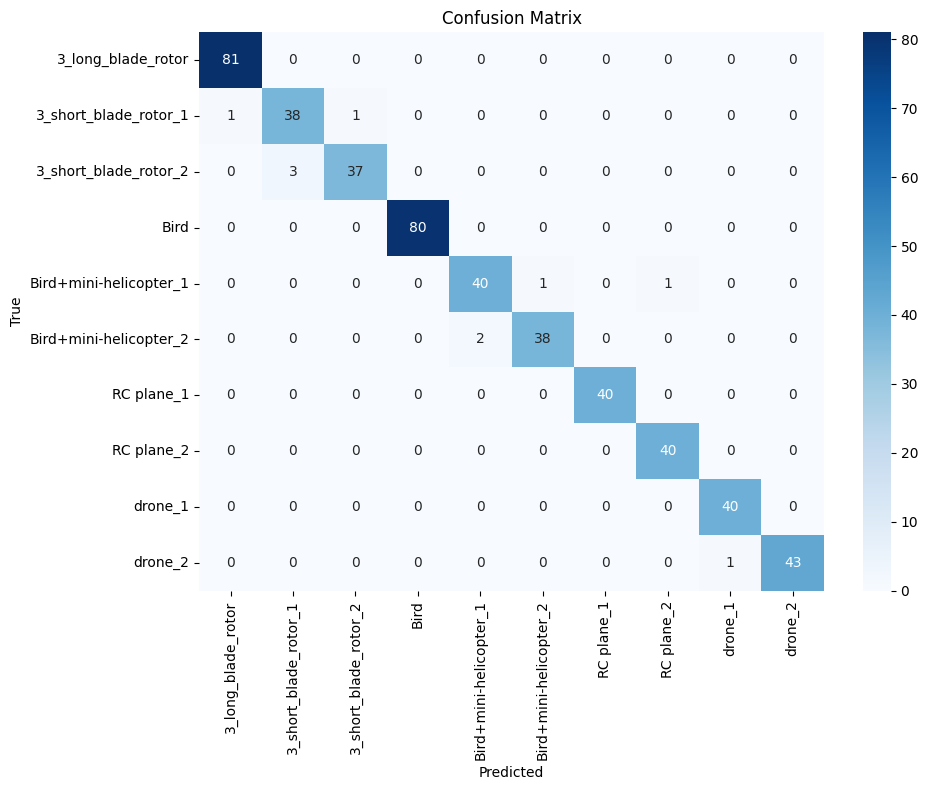

ROC curves saved to /kaggle/working/cspd_output/roc_curves.png


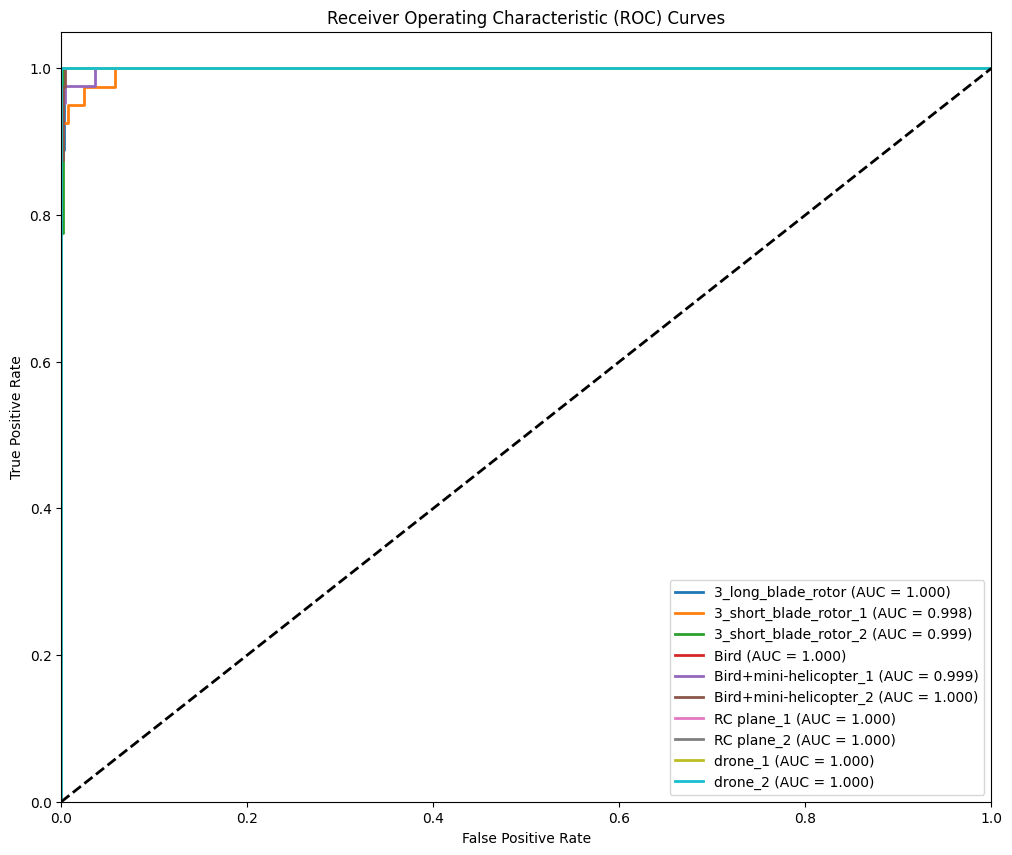

Zoomed ROC curves saved to /kaggle/working/cspd_output/roc_curves_zoomed.png


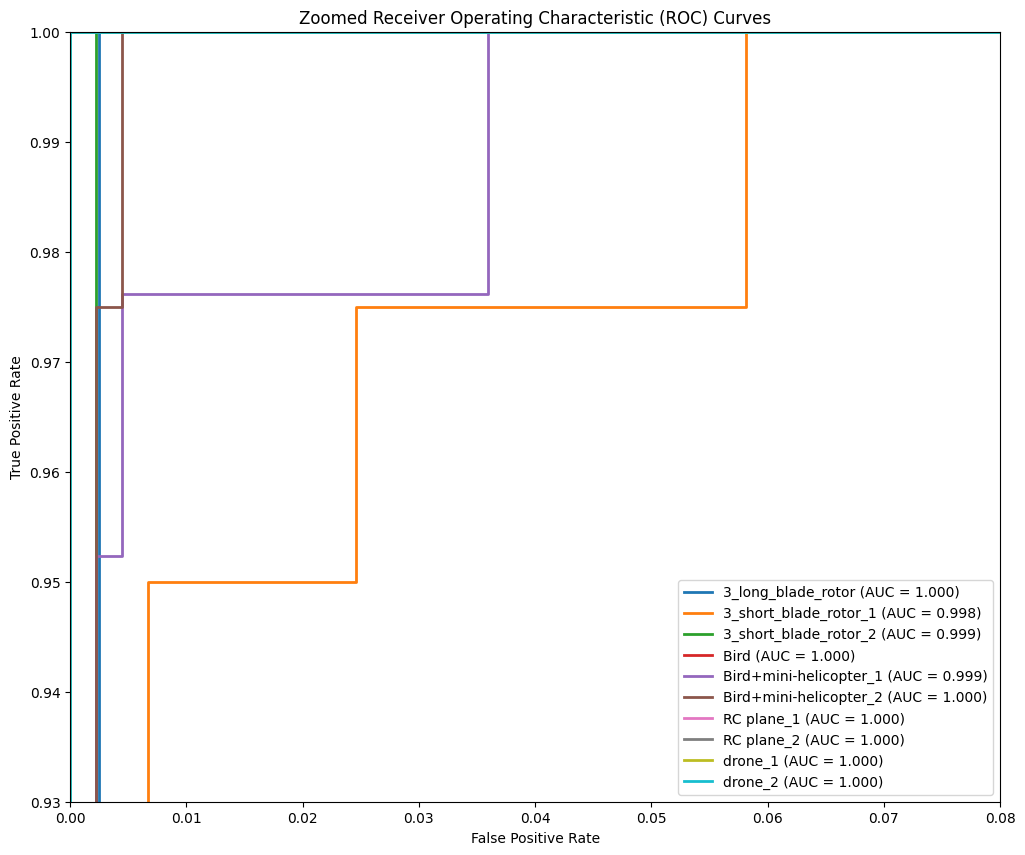


Evaluation completed. Results saved to /kaggle/working/cspd_output

Model Efficiency Summary:
  • FLOPs: 2.266G
  • Parameters: 3.625M
  • Inference Time: 13.73ms per image


In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
# Import thop for FLOPs calculation
from thop import profile, clever_format

# Import model architecture from the first cell
# Note: In a Jupyter/Colab environment, you don't need to reimport 
# if the model architecture is already defined in previous cells

#-------------------------------------------------------------------------------
# PART 1: MODEL LOADING AND DATASET PREPARATION
#-------------------------------------------------------------------------------

def load_best_model(model_path, device):
    """Load the best model from checkpoint"""
    checkpoint = torch.load(model_path, map_location=device)
    num_classes = checkpoint['num_classes']
    class_names = checkpoint.get('class_names', None)
    
    # If class_names is not in the checkpoint, try to load them from a file
    if class_names is None and os.path.exists(os.path.join(os.path.dirname(model_path), "class_names.txt")):
        with open(os.path.join(os.path.dirname(model_path), "class_names.txt"), "r") as f:
            class_names = [line.strip() for line in f.readlines()]
    
    # Recreate the model
    model = CSPDModel(in_channels=3, base_channels=16, num_classes=num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    return model, class_names, checkpoint['val_acc']

def get_test_loader(test_dir, img_size=224, batch_size=32, num_workers=4):
    """Create test data loader"""
    test_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_dataset = DroneDataset(root_dir=test_dir, transform=test_transform)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, 
        num_workers=num_workers, pin_memory=True
    )
    
    return test_loader, test_dataset.classes

#-------------------------------------------------------------------------------
# PART 2: MODEL COMPLEXITY CALCULATION FUNCTIONS
#-------------------------------------------------------------------------------

def calculate_model_complexity(model, img_size=224, device='cuda'):
    """
    Calculate model complexity metrics including FLOPs and parameters
    
    Args:
        model: PyTorch model
        img_size: Input image size
        device: Device to run calculation on
        
    Returns:
        dict: Dictionary with complexity metrics
    """
    # Create a dummy input tensor
    dummy_input = torch.randn(1, 3, img_size, img_size).to(device)
    
    # Use thop to profile the model
    flops, params = profile(model, inputs=(dummy_input,), verbose=False)
    
    # Calculate MACs (Multiply-Accumulate Operations, often considered as half of FLOPs)
    macs = flops / 2
    
    # Format numbers for better readability
    flops_readable, params_readable, macs_readable = clever_format([flops, params, macs], "%.3f")
    
    # Measure actual inference time
    start_time = time.time()
    with torch.no_grad():
        for _ in range(10):  # Average over multiple runs
            _ = model(dummy_input)
    inference_time = (time.time() - start_time) / 10 * 1000  # Convert to ms
    
    # Calculate efficiency metrics
    flops_per_param = flops / params if params > 0 else 0
    
    return {
        'flops': flops,
        'flops_readable': flops_readable,
        'macs': macs,
        'macs_readable': macs_readable,
        'params': params,
        'params_readable': params_readable,
        'inference_time_ms': inference_time,
        'flops_per_param': flops_per_param
    }

def print_model_complexity(complexity_metrics):
    """
    Print model complexity metrics in a readable format
    
    Args:
        complexity_metrics: Dictionary of complexity metrics
    """
    print("\n" + "="*50)
    print("MODEL COMPLEXITY ANALYSIS")
    print("="*50)
    
    print(f"FLOPs: {complexity_metrics['flops_readable']} ({complexity_metrics['flops']:,})")
    print(f"MACs: {complexity_metrics['macs_readable']} ({complexity_metrics['macs']:,})")
    print(f"Parameters: {complexity_metrics['params_readable']} ({complexity_metrics['params']:,})")
    print(f"Inference time: {complexity_metrics['inference_time_ms']:.2f} ms per image")
    print(f"FLOPs per parameter: {complexity_metrics['flops_per_param']:.2f}")
    
    # Model complexity classification based on FLOPs
    if complexity_metrics['flops'] < 500_000_000:  # 0.5 GFLOPs
        complexity_class = "Very Lightweight (Mobile-Friendly)"
    elif complexity_metrics['flops'] < 2_000_000_000:  # 2 GFLOPs
        complexity_class = "Lightweight"
    elif complexity_metrics['flops'] < 10_000_000_000:  # 10 GFLOPs
        complexity_class = "Moderate"
    elif complexity_metrics['flops'] < 50_000_000_000:  # 50 GFLOPs
        complexity_class = "Heavy"
    else:
        complexity_class = "Very Heavy"
        
    print(f"Complexity Classification: {complexity_class}")
    
    # Comparison with common models
    print("\nComparison with common models:")
    print("  • MobileNetV2: ~0.3 GFLOPs")
    print("  • EfficientNet-B0: ~0.4 GFLOPs")
    print("  • ResNet-18: ~1.8 GFLOPs")
    print("  • ResNet-50: ~4.1 GFLOPs")
    print("  • VGG-16: ~15.5 GFLOPs")
    print("="*50)

#-------------------------------------------------------------------------------
# PART 3: EVALUATION FUNCTIONS
#-------------------------------------------------------------------------------

def test(model, dataloader, device, class_names=None):
    """Test the model and return detailed metrics"""
    model.eval()
    correct = 0
    total = 0
    
    # Store predictions and ground truth
    all_preds = []
    all_targets = []
    all_probs = []  # For ROC curve
    
    # Measure inference time
    start_time = time.time()
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Testing"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward
            outputs = model(inputs)
            
            # Store probabilities
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            
            # Get predictions
            _, predicted = outputs.max(1)
            
            # Update statistics
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store predictions and targets
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    all_probs = np.concatenate(all_probs, axis=0)
    
    # Calculate overall accuracy
    accuracy = 100 * correct / total
    
    # Calculate inference time
    inference_time = time.time() - start_time
    avg_time_per_sample = inference_time / total
    
    print(f"\nTest Results:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Total inference time: {inference_time:.4f}s")
    print(f"  Average inference time per sample: {avg_time_per_sample*1000:.2f}ms")
    
    # Calculate per-class accuracy
    class_accuracies = {}
    if class_names:
        class_correct = list(0. for _ in range(len(class_names)))
        class_total = list(0. for _ in range(len(class_names)))
        
        for pred, target in zip(all_preds, all_targets):
            class_correct[target] += int(pred == target)
            class_total[target] += 1
        
        print("\nPer-class accuracy:")
        for i, name in enumerate(class_names):
            if class_total[i] > 0:
                acc = 100 * class_correct[i] / class_total[i]
                class_accuracies[name] = acc
                print(f"  {name}: {acc:.2f}%")
    
    return {
        'accuracy': accuracy,
        'inference_time': inference_time,
        'avg_time_per_sample': avg_time_per_sample,
        'class_accuracies': class_accuracies,
        'predictions': all_preds,
        'targets': all_targets,
        'probabilities': all_probs
    }

def plot_confusion_matrix(targets, predictions, class_names, save_path=None):
    """Plot and optionally save confusion matrix"""
    cm = confusion_matrix(targets, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")
    
    plt.show()
def plot_roc_curves(targets, probabilities, class_names, save_path=None, save_zoomed_path=None):
    """Plot ROC curves for all classes and a zoomed version for high accuracy region"""
    n_classes = len(class_names)
    
    # Binarize the labels for multi-class ROC
    y_bin = label_binarize(targets, classes=range(n_classes))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot all ROC curves
    plt.figure(figsize=(12, 10))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    
    if save_path:
        plt.savefig(save_path)
        print(f"ROC curves saved to {save_path}")
    
    plt.show()
    
    # Plot zoomed ROC curve with the specified axis limits
    plt.figure(figsize=(12, 10))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 0.08])  # Updated: Zoom on x-axis from 0.0 to 0.08
    plt.ylim([0.93, 1.0])  # Updated: y-axis from 0.93 to 1.0
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Zoomed Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    
    if save_zoomed_path:
        plt.savefig(save_zoomed_path)
        print(f"Zoomed ROC curves saved to {save_zoomed_path}")
    
    plt.show()
    
    return roc_auc

#-------------------------------------------------------------------------------
# PART 4: MAIN TESTING FUNCTION WITH FLOPS CALCULATION
#-------------------------------------------------------------------------------

def run_evaluation():
    # Set parameters
    batch_size = 32
    img_size = 224
    num_workers = 4
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Set data directories - adjust as needed
    output_dir = "/kaggle/working/cspd_output"
    test_dir = os.path.join(output_dir, 'test')
    
    # Path to the saved model
    model_path = os.path.join(output_dir, "best_model.pth")
    
    print(f"Using device: {device}")
    
    # Load model
    print(f"Loading model from {model_path}...")
    model, class_names, best_val_acc = load_best_model(model_path, device)
    print(f"Loaded model with validation accuracy: {best_val_acc:.2f}%")
    
    # Calculate model complexity
    print("\nCalculating model complexity (FLOPs, parameters, etc.)...")
    complexity_metrics = calculate_model_complexity(model, img_size=img_size, device=device)
    print_model_complexity(complexity_metrics)
   
    # Create test loader
    test_loader, _ = get_test_loader(test_dir, img_size, batch_size, num_workers)
    print(f"Test samples: {len(test_loader.dataset)}")
    
    # Run test evaluation
    results = test(model, test_loader, device, class_names)
    
    # Plot confusion matrix
    plot_confusion_matrix(
        results['targets'], 
        results['predictions'], 
        class_names,
        save_path=os.path.join(output_dir, "confusion_matrix.png")
    )
    
    # Plot ROC curves
    roc_auc = plot_roc_curves(
        results['targets'], 
        results['probabilities'], 
        class_names,
        save_path=os.path.join(output_dir, "roc_curves.png"),
        save_zoomed_path=os.path.join(output_dir, "roc_curves_zoomed.png")
    )
    
    # Save complexity results
    complexity_results = {
        'flops': int(complexity_metrics['flops']),
        'macs': int(complexity_metrics['macs']),
        'params': int(complexity_metrics['params']),
        'inference_time_ms': float(complexity_metrics['inference_time_ms']),
        'flops_per_param': float(complexity_metrics['flops_per_param'])
    }
    
    # Save results
    evaluation_results = {
        'accuracy': results['accuracy'],
        'inference_time': results['inference_time'],
        'avg_time_per_sample_ms': results['avg_time_per_sample'] * 1000,
        'class_accuracies': results['class_accuracies'],
        'roc_auc': {class_names[i]: roc_auc[i] for i in range(len(class_names))},
        'complexity': complexity_results  # Add complexity results
    }
    
    with open(os.path.join(output_dir, "evaluation_results.json"), "w") as f:
        json.dump(evaluation_results, f, indent=4)
    
    print(f"\nEvaluation completed. Results saved to {output_dir}")
    
    # Print out key complexity metrics again
    print("\nModel Efficiency Summary:")
    print(f"  • FLOPs: {complexity_metrics['flops_readable']}")
    print(f"  • Parameters: {complexity_metrics['params_readable']}")
    print(f"  • Inference Time: {complexity_metrics['inference_time_ms']:.2f}ms per image")
    
    return model, results, complexity_metrics

# Run the evaluation
if __name__ == "__main__":
    model, results, complexity = run_evaluation()

# Model summary and visualization

In [4]:
def custom_model_summary(model):
    """
    Create a custom model summary that works with complex architectures
    that have multiple inputs/outputs between layers
    """
    print("\nDetailed Model Summary:")
    print("=" * 80)
    print(f"{'Layer Type':<40} {'Output Shape':<25} {'Param #':<15}")
    print("-" * 80)
    
    def summarize_module(module, prefix=''):
        total_params = 0
        for name, param in module.named_parameters():
            if '.' not in name:  # Only direct parameters of this module
                total_params += param.numel()
        
        # Try to infer output shape for common layer types
        shape_str = "Unknown"
        
        # Print information about this module
        print(f"{prefix + module.__class__.__name__:<40} {shape_str:<25} {total_params:<15,}")
        
        # Recursively print information about child modules
        for name, child in module.named_children():
            child_prefix = f"{prefix}{name}."
            summarize_module(child, child_prefix)
            
    # Start from the top-level module
    summarize_module(model)
    
    # Print total parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    model_size_mb = sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024)
    
    print("-" * 80)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {trainable_params:,}")
    print(f"Non-trainable params: {total_params - trainable_params:,}")
    print(f"Model size in MB: {model_size_mb:.3f} MB")
    print(f"Model size in KB: {model_size_mb * 1024:.3f} KB")
    print("=" * 80)

def print_model_structure(model):
    """Print a text-based hierarchical representation of the model structure"""
    print("\nModel Structure:")
    print("=" * 80)
    
    def print_module(module, depth=0):
        indent = "  " * depth
        params = sum(p.numel() for p in module.parameters())
        print(f"{indent}├─ {module.__class__.__name__} ({params:,} params)")
        
        for name, child in module.named_children():
            print(f"{indent}│  └─ {name}:")
            print_module(child, depth + 2)
    
    print_module(model)
    print("=" * 80)


# Define output directory
output_dir = "/kaggle/working/cspd_output"
os.makedirs(output_dir, exist_ok=True)

# Call each visualization function individually
print("\nGenerating Model Summary...")
custom_model_summary(model)

print("\nGenerating Model Structure...")
print_model_structure(model)


Generating Model Summary...

Detailed Model Summary:
Layer Type                               Output Shape              Param #        
--------------------------------------------------------------------------------
CSPDModel                                Unknown                   0              
backbone.CSPDBackbone                    Unknown                   0              
backbone.conv1.CBS                       Unknown                   0              
backbone.conv1.conv.Conv                 Unknown                   0              
backbone.conv1.conv.conv.Conv2d          Unknown                   432            
backbone.conv1.bn.BN                     Unknown                   0              
backbone.conv1.bn.bn.BatchNorm2d         Unknown                   32             
backbone.conv1.silu.SiLU                 Unknown                   0              
backbone.conv1.silu.silu.SiLU            Unknown                   0              
backbone.down1.CBS                 